# 前準備

In [41]:
%%capture
#!pip install linearmodels

In [74]:
import hashlib

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import polars.selectors as cs
pl.Config(fmt_str_lengths = 100, tbl_cols = 100, tbl_rows = 10)
import seaborn as sns
import statsmodels.formula.api as smf
from linearmodels.iv import IV2SLS
from scipy import stats
from statsmodels.iolib.summary2 import summary_col
from tqdm import tqdm

URL_LENTA_DATA = "https://raw.githubusercontent.com/HirotakeIto/intro_to_impact_evaluation_with_python/main/data/lenta_dataset.csv"
URL_CLUSTER_TRIAL = "https://raw.githubusercontent.com/HirotakeIto/intro_to_impact_evaluation_with_python/main/data/ch3_cluster_trial.csv"
URL_STRATIFIED_TRIAL = "https://raw.githubusercontent.com/HirotakeIto/intro_to_impact_evaluation_with_python/main/data/ch3_stratified_trial.csv"
URL_AATEST = "https://raw.githubusercontent.com/HirotakeIto/intro_to_impact_evaluation_with_python/main/data/ch3_aatest_trial.csv"
URL_NONCOMPLIANCE = "https://raw.githubusercontent.com/HirotakeIto/intro_to_impact_evaluation_with_python/main/data/ch3_noncompliance_abtest.csv"

# A/Bテストについての発展的な話題

## A/Aテスト：A/Bテスト設計の妥当性を確認する
### プログラム3.1 割当単位と分析単位が不一致な場合の回帰分析

書籍上では次のようなコードになっています。
```python
import pandas as pd
import statsmodels.formula.api as smf

df_cluster_trial = pd.read_csv(URL_CLUSTER_TRIAL)
result = smf.ols(
    formula="is_click ~ is_treatment", data=df_cluster_trial
).fit()
result.summary().tables[1]
```

In [43]:
df_cluster_trial = pl.read_csv(URL_CLUSTER_TRIAL)
result = smf.ols(
    formula = "is_click ~ is_treatment", data = df_cluster_trial
).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.5216,0.008,69.521,0.000,0.507,0.536
is_treatment,-0.0232,0.010,-2.365,0.018,-0.043,-0.004


In [44]:
df_cluster_trial

uid,is_treatment,is_click
i64,i64,i64
0,0,1
0,0,0
0,0,0
0,0,0
0,0,0
0,0,0
0,0,1
0,0,0
0,0,1


### プログラム3.2 A/A テストの分析（A/A テストが成功しているとき）
書籍上では次のようなコードになっています。

```python
df_aatest = pd.read_csv(URL_AATEST)
result = smf.ols(
    formula="is_click~is_treatment", data=df_aatest
).fit()
result.summary().tables[1]
```

In [45]:
df_aatest = pl.read_csv(URL_AATEST)
result = smf.ols(
    formula = "is_click~is_treatment", data = df_aatest
).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.4988,0.007,70.327,0.000,0.485,0.513
is_treatment,0.0102,0.010,1.015,0.310,-0.009,0.030


In [46]:
df_aatest

imp_id,is_treatment,is_click
i64,i64,i64
0,1,0
1,1,0
2,1,1
3,0,1
4,0,1
5,0,0
6,0,1
7,0,1
8,0,1


### プログラム3.3 A/A テストのリプレイ

書籍上では次のようなコードになっています。
```python
import hashlib

import numpy as np
from tqdm import tqdm

def assign_treatment_randomly(imp_id, salt):
    return (
        int(hashlib.sha256(f"{salt}_{imp_id}".encode()).hexdigest(), 16)
        % 2
    )


# セットアップ
df_aatest = pd.read_csv(URL_AATEST)
rng = np.random.default_rng(seed=0)
replays = []
# for-loopによる繰り返し処理
for i in tqdm(range(300)):
    # 擬似的な割当
    salt = f"salt{i}"
    df_aatest["is_treatment_in_aa"] = df_aatest["imp_id"].apply(
        assign_treatment_randomly, salt=salt
    )
    # 擬似的な割当の下での分析
    result = smf.ols(
        formula="is_click ~ is_treatment_in_aa", data=df_aatest
    ).fit()
    pvalue = result.pvalues["is_treatment_in_aa"]
    # 情報の格納
    replays.append(pvalue)
```

In [47]:
def assign_treatment_randomly(imp_id, salt):
    '''
    施策対象者を割り当てる関数
    '''
    return (
        int(hashlib.sha256(f"{salt}_{imp_id}".encode()).hexdigest(), 16)
        % 2
    )


# セットアップ
df_aatest = pl.read_csv(URL_AATEST)
rng = np.random.default_rng(seed = 0)
replays = []
# for-loopによる繰り返し処理
for i in tqdm(range(300)):
    # 擬似的な割当
    salt = f"salt{i}"
    df_aatest = (
        df_aatest
        .with_columns(
            pl.col("imp_id")
            .map_elements(lambda x: assign_treatment_randomly(imp_id = x, salt = salt), return_dtype = pl.Int64)
            .alias("is_treatment_in_aa")
        )
    )
    # 擬似的な割当の下での分析
    result = smf.ols(
        formula = "is_click ~ is_treatment_in_aa", data = df_aatest
    ).fit()
    pvalue = result.pvalues["is_treatment_in_aa"]
    # 情報の格納
    replays.append(pvalue)

100%|██████████| 300/300 [00:09<00:00, 33.30it/s]


### プログラム3.4 A/A テストのリプレイの可視化
本文では次のようになっています。
```python
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.hist(replays)
ax.set_facecolor("none")
ax.set_xlabel("pvalue")
ax.set_title("distribution of pvalue")
plt.show()
```

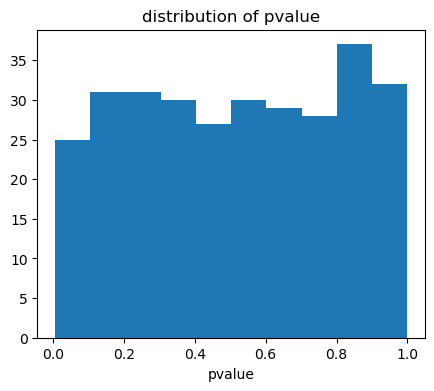

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.hist(replays)
ax.set_facecolor("none")
ax.set_xlabel("pvalue")
ax.set_title("distribution of pvalue")
plt.show()

### プログラム3.5 コルモゴロフ─スミルノフ検定による分布の確認
本文では次のようになっています。
``` python
from scipy import stats

stats.kstest(replays, "uniform", args=(0, 1))
```

In [49]:
stats.kstest(replays, "uniform", args=(0, 1))

KstestResult(statistic=0.04504551195894568, pvalue=0.561121550893019, statistic_location=0.688378845292279, statistic_sign=-1)

## 状況に応じたA/Bテストのモデリング

### クラスターA/BテストCluster A/B Test 

#### プログラム3.6 クラスターA/B テストデータにおけるA/A テストのリプレイ

本文では次のようになっています。
```python
def assign_treatment_randomly(uid, salt):
    return (
        int(hashlib.sha256(f"{salt}_{uid}".encode()).hexdigest(), 16)
        % 2
    )


df_cluster = pd.read_csv(URL_CLUSTER_TRIAL)
rng = np.random.default_rng(seed=0)
replays = []
for i in tqdm(range(300)):
    # 擬似的な割当
    salt = f"salt{i}"
    df_cluster["is_treatment_in_aa"] = df_cluster["uid"].apply(
        assign_treatment_randomly, salt=salt
    )
    # 擬似的な割当の下での分析
    result = smf.ols(
        formula="is_click ~ is_treatment_in_aa", data=df_cluster
    ).fit()
    pvalue = result.pvalues["is_treatment_in_aa"]
    # 情報の格納
    replays.append(pvalue)
```

In [50]:
def assign_treatment_randomly(uid, salt):
    return (
        int(hashlib.sha256(f"{salt}_{uid}".encode()).hexdigest(), 16)
        % 2
    )


df_cluster = pl.read_csv(URL_CLUSTER_TRIAL)
rng = np.random.default_rng(seed = 0)
replays = []
for i in tqdm(range(300)):
    # 擬似的な割当
    salt = f"salt{i}"
    df_cluster = (
        df_cluster
        .with_columns(
            pl.col("uid")
            .map_elements(lambda x: assign_treatment_randomly(uid = x, salt = salt), return_dtype = pl.Int64)
            .alias("is_treatment_in_aa")
        )
    )
    # 擬似的な割当の下での分析
    result = smf.ols(
        formula = "is_click ~ is_treatment_in_aa", data = df_cluster
    ).fit()
    pvalue = result.pvalues["is_treatment_in_aa"]
    # 情報の格納
    replays.append(pvalue)

100%|██████████| 300/300 [00:09<00:00, 32.61it/s]


In [51]:
df_cluster

uid,is_treatment,is_click,is_treatment_in_aa
i64,i64,i64,i64
0,0,1,0
0,0,0,0
0,0,0,0
0,0,0,0
0,0,0,0
0,0,0,0
0,0,1,0
0,0,0,0
0,0,1,0


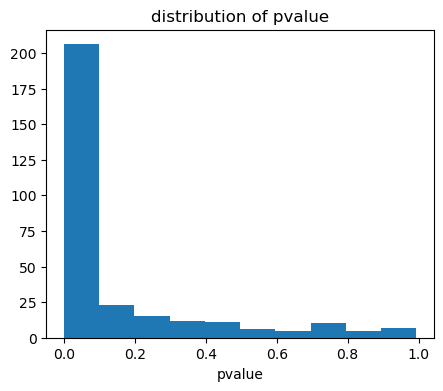

In [52]:
fig, ax = plt.subplots(1, 1, figsize = (5, 4))
ax.hist(replays)
ax.set_facecolor("none")
ax.set_xlabel("pvalue")
ax.set_title("distribution of pvalue")
plt.show()

In [53]:
stats.kstest(replays, "uniform", args = (0, 1))

KstestResult(statistic=0.6134127868407012, pvalue=4.700198099441234e-109, statistic_location=0.056587213159298794, statistic_sign=1)

#### プログラム3.7 クラスターA/B テストデータの分析
本書では次のようなコードになっています
```python
df_cluster_trial = pd.read_csv(URL_CLUSTER_TRIAL)
# 施策効果の推定
result = smf.ols(
    formula="is_click ~ is_treatment", data=df_cluster_trial
).fit()
# クラスター頑健標準誤差を用いて分析する
result_corrected = result.get_robustcov_results(
    "cluster", groups=df_cluster_trial["uid"]
)
result_corrected.summary().tables[1]
```

In [54]:
df_cluster_trial = pl.read_csv(URL_CLUSTER_TRIAL)
# 施策効果の推定
result = smf.ols(
    formula="is_click ~ is_treatment", data = df_cluster_trial
).fit()
# クラスター頑健標準誤差を用いて分析する
result_corrected = result.get_robustcov_results(
    "cluster", groups = df_cluster_trial["uid"].to_pandas()
)
result_corrected.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.5216,0.033,15.632,0.000,0.456,0.587
is_treatment,-0.0232,0.043,-0.539,0.590,-0.108,0.062


In [55]:
df_cluster_trial

uid,is_treatment,is_click
i64,i64,i64
0,0,1
0,0,0
0,0,0
0,0,0
0,0,0
0,0,0
0,0,1
0,0,0
0,0,1


#### プログラム3.8 クラスターA/BテストデータのA/Aテスト

``` python
def assign_treatment_randomly(uid, salt):
    return (
        int(hashlib.sha256(f"{salt}_{uid}".encode()).hexdigest(), 16)
        % 2
    )


rng = np.random.default_rng(seed=0)
replays = []
for i in tqdm(range(300)):
    # 擬似的な割り当て    
    salt = f"salt{i}"
    df_cluster["is_treatment_in_aa"] = df_cluster["uid"].apply(
        assign_treatment_randomly, salt=salt
    )
    # 分析    
    result = smf.ols(
        formula="is_click ~ is_treatment_in_aa", data=df_cluster
    ).fit()
    result_corrected = result.get_robustcov_results(
        "cluster", groups=df_cluster["uid"]
    )
    pvalue = result_corrected.pvalues[
        result_corrected.model.exog_names.index("is_treatment_in_aa")
    ]
    # 情報の格納    
    replays.append(pvalue)
```

In [56]:
def assign_treatment_randomly(uid, salt):
    return (
        int(hashlib.sha256(f"{salt}_{uid}".encode()).hexdigest(), 16)
        % 2
    )


rng = np.random.default_rng(seed = 0)
replays = []
for i in tqdm(range(300)):
    # 擬似的な割り当て
    salt = f"salt{i}"
    df_cluster = (
        df_cluster
        .with_columns(
            pl.col("uid")
            .map_elements(lambda x: assign_treatment_randomly(uid = x, salt = salt), return_dtype = pl.Int64)
            .alias("is_treatment_in_aa")
        )
    )
    # 分析
    result = smf.ols(
        formula = "is_click ~ is_treatment_in_aa", data = df_cluster
    ).fit()
    result_corrected = result.get_robustcov_results(
        "cluster", groups = df_cluster["uid"].to_pandas()
    )
    pvalue = result_corrected.pvalues[
        result_corrected.model.exog_names.index("is_treatment_in_aa")
    ]
    # 情報の格納
    replays.append(pvalue)

100%|██████████| 300/300 [00:10<00:00, 28.56it/s]


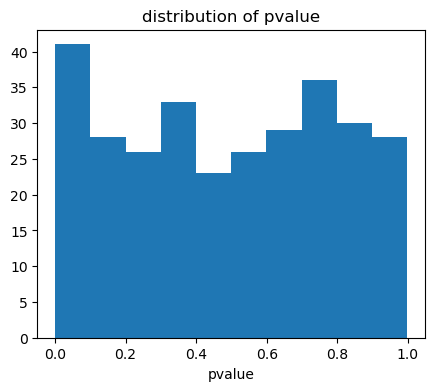

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.hist(replays)
ax.set_facecolor("none")
ax.set_xlabel("pvalue")
ax.set_title("distribution of pvalue")
plt.show()

In [58]:
# 本文には掲載していない
stats.kstest(replays, "uniform", args = (0, 1))

KstestResult(statistic=0.0431918216683526, pvalue=0.6145727388837272, statistic_location=0.08347484499831408, statistic_sign=1)

### 層化A/Bテスト Stratified A/B Test

#### プログラム3.9 シミュレーション：ランダムな割り当てをした場合の性別割合の偏り
本文では次のように掲載しています。
``` python
rng = np.random.default_rng(seed=0)
ratio = [
    rng.choice([0, 1], p=[0.5, 0.5], size=500).mean()
    for _ in range(100)
]
plt.hist(ratio)
plt.xlabel("male ratio")
plt.ylabel("frequency")
plt.show()
```

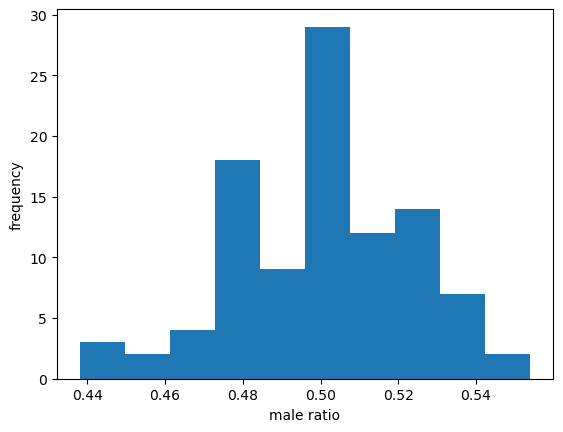

In [59]:
rng = np.random.default_rng(seed = 0)
ratio = [
    rng.choice([0, 1], p = [0.5, 0.5], size = 500).mean()
    for _ in range(100)
]
plt.hist(ratio)
plt.xlabel("male ratio")
plt.ylabel("frequency")
plt.show()

#### プログラム3.10 層化A/B テストにおけるランダムな割り当て
本文では次のように掲載しています。

``` python
import seaborn as sns

def assign_strata(df_group, ratio_treat, rng, column_name):
    num_samples = round(len(df_group) * ratio_treat)
    df_group[column_name] = 0
    treat_indices = rng.choice(
        df_group.index, num_samples, replace=False
    )
    df_group.loc[treat_indices, column_name] = 1
    return df_group


# データの読み込み
df_titanic = sns.load_dataset("titanic")[
    ["survived", "sex", "pclass"]
]
# groupbyメソッドを用いて無作為抽出
rng = np.random.default_rng(11)
df_titanic_assigned = df_titanic.groupby(
    ["sex", "pclass"], group_keys=False
).apply(
    assign_strata, ratio_treat=0.3, column_name="is_treat", rng=rng
)
```

In [60]:
def assign_strata(df_group, ratio_treat, rng, column_name):
    num_samples = round(len(df_group) * ratio_treat)
    column_name_ndarray = np.zeros(len(df_group))
    treat_indices = rng.choice(
        range(len(df_group)), num_samples, replace=False
    )
    column_name_ndarray[treat_indices] = 1
    df_group_clone = df_group.clone()
    df_group_clone = df_group_clone.with_columns(pl.Series(column_name, column_name_ndarray))
    return df_group_clone


# データの読み込み
df_titanic = pl.from_pandas(sns.load_dataset("titanic")[
    ["survived", "sex", "pclass"]
])
# groupbyメソッドを用いて無作為抽出
rng = np.random.default_rng(11)
df_titanic_assigned = (
    df_titanic
    .group_by("sex", "pclass")
    .map_groups(lambda x: assign_strata(df_group = x, ratio_treat = 0.3, rng = rng, column_name = "is_treat"))
)

In [61]:
df_titanic_assigned

survived,sex,pclass,is_treat
i64,str,i64,f64
1,"""female""",1,0.0
1,"""female""",1,0.0
1,"""female""",1,1.0
1,"""female""",1,0.0
1,"""female""",1,0.0
1,"""female""",1,1.0
1,"""female""",1,0.0
1,"""female""",1,0.0
1,"""female""",1,1.0


#### プログラム3.11　サブグループごとの割当比率を確認する

In [62]:
df_titanic_assigned.group_by("sex", "pclass").agg(pl.mean("is_treat")).sort("sex", "pclass")

sex,pclass,is_treat
str,i64,f64
"""female""",1,0.297872
"""female""",2,0.302632
"""female""",3,0.298611
"""male""",1,0.303279
"""male""",2,0.296296
"""male""",3,0.299712


#### 層化A/Bテストの分析の実装

#### プログラム3.12 層化A/B テストの分析（通常のA/B テストと同様に行った場合）
本書では次のように掲載しています。
``` python
df_stratified = pd.read_csv(URL_STRATIFIED_TRIAL)
# 分析
result = smf.ols(formula="y ~ is_treatment", data=df_stratified).fit()
result.summary().tables[1]
```

In [63]:
df_stratified = pl.read_csv(URL_STRATIFIED_TRIAL)
# 分析
result = smf.ols(formula = "y ~ is_treatment", data = df_stratified).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-5.9951,0.332,-18.036,0.000,-6.654,-5.336
is_treatment,0.5530,0.468,1.182,0.240,-0.375,1.481


In [64]:
df_stratified

is_treatment,group_name,y
i64,i64,f64
0,0,-7.094851
0,0,-2.853676
1,0,-3.024156
1,0,-4.989469
1,0,-2.72484
1,0,-4.821004
0,0,-5.207207
0,0,-3.675816
1,0,-4.375619


#### プログラム3.13 層化 A/B テストの分析（ダミー変数を利用した場合）
``` python
result = smf.ols(
    formula="y ~ is_treatment + C(group_name)", data=df_stratified
).fit()
result.summary().tables[1]
```

In [65]:
result = smf.ols(
    formula = "y ~ is_treatment + C(group_name)", data = df_stratified.to_pandas()
).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-4.7373,0.141,-33.649,0.000,-5.016,-4.458
C(group_name)[T.1],-5.2247,0.216,-24.182,0.000,-5.653,-4.796
is_treatment,0.5301,0.184,2.878,0.005,0.165,0.895


## 処置と割当の不一致 A/B テストにおける Non-compliance
#### プログラム3.14 施策意図の効果の分析：Intent to Treat
本文では次のように掲載しています。
``` python
df_noncompliance = pd.read_csv(URL_NONCOMPLIANCE)
# Intent to Treatの分析
result = smf.ols(
    formula="purchase ~ assignment", data=df_noncompliance
).fit()
result.summary().tables[1]
```

In [66]:
df_noncompliance = pl.read_csv(URL_NONCOMPLIANCE)
# Intent to Treatの分析
result = smf.ols(
    formula = "purchase ~ assignment", data = df_noncompliance
).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,9918.2820,64.690,153.321,0.000,9791.338,1e+04
assignment,197.0536,92.320,2.134,0.033,15.890,378.217


In [67]:
df_noncompliance

assignment,x,is_deliver,purchase
f64,f64,f64,f64
0.0,0.017286,0.0,10563.182011
1.0,-0.037921,1.0,8861.781424
1.0,0.056103,0.0,11450.231477
1.0,-0.213583,0.0,8357.833101
0.0,0.023237,0.0,10755.016507
0.0,0.002813,0.0,9887.109547
1.0,-0.137034,1.0,9763.129997
1.0,0.21756,1.0,11536.532317
0.0,-0.138741,0.0,8392.004915


#### プログラム3.15 平均的な開封割合の確認

In [69]:
df_noncompliance.group_by("assignment").agg(pl.mean("is_deliver")).sort("assignment")

assignment,is_deliver
f64,f64
0.0,0.0
1.0,0.450102


####  プログラム3.16 操作変数法の2段階推定による施策効果を復元する分析
本文では次のように掲載しています。

``` python
from linearmodels.iv import IV2SLS

# 操作変数法の2段階推定
iv = IV2SLS.from_formula(
    formula="purchase ~ 1 + [is_deliver ~ assignment] + x",
    data=df_noncompliance,
).fit()
iv.summary.tables[1]
```

In [71]:
# 操作変数法の2段階推定
iv = IV2SLS.from_formula(
    formula = "purchase ~ 1 + [is_deliver ~ assignment] + x",
    data = df_noncompliance.to_pandas(),
).fit()
iv.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,9943.6,42.853,232.04,0.0000,9859.6,1.003e+04
x,9714.6,290.72,33.416,0.0000,9144.8,1.028e+04
is_deliver,533.98,141.26,3.7802,0.0002,257.12,810.84


In [72]:
iv.first_stage

,is_deliver
R-squared,0.3018
Partial R-squared,0.2977
Shea's R-squared,0.2977
Partial F-statistic,408.62
P-value (Partial F-stat),0.0000
Partial F-stat Distn,chi2(1)
==========================,==========
Intercept,0.0009
,(0.5299)
x,0.3463


# 共変量を入れて分析をする
#### プログラム3.17 共変量を考慮したA/B テストの分析
本文では次のように記していました。
``` python
df_abtest = pd.read_csv(URL_LENTA_DATA)
result_with_covariates = smf.ols(
    formula="response_att ~ is_treatment + food_share_15d + age + is_women",
    data=df_abtest,
).fit()
result_with_covariates.summary().tables[1]
```

In [73]:
df_abtest = pl.read_csv(URL_LENTA_DATA)
result_with_covariates = smf.ols(
    formula = "response_att ~ is_treatment + food_share_15d + age + is_women",
    data = df_abtest,
).fit()
result_with_covariates.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.0539,0.005,10.555,0.000,0.044,0.064
is_treatment,0.0072,0.003,2.285,0.022,0.001,0.013
food_share_15d,0.1713,0.003,51.131,0.000,0.165,0.178
age,-0.0003,9.3e-05,-3.047,0.002,-0.000,-0.000
is_women,0.0033,0.003,1.157,0.247,-0.002,0.009


In [75]:
df_abtest

is_treatment,response_att,food_share_15d,age,is_women
i64,i64,f64,f64,i64
1,0,0.0,33.0,1
0,0,0.0,63.0,1
1,0,0.0,51.0,1
0,0,0.0,38.0,1
1,0,0.5105,20.0,1
…,…,…,…,…
1,0,0.0,60.0,1
0,0,0.0,26.0,0
1,0,0.8461,28.0,1


- A/Bテストの結果再掲

In [76]:
result_plain = smf.ols(
    formula = "response_att ~ is_treatment ", data = df_abtest
).fit()
result_plain.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1024,0.003,36.412,0.000,0.097,0.108
is_treatment,0.0091,0.003,2.809,0.005,0.003,0.015


# 施策効果の異質性 ~ どこで効果があるのか知る

#### プログラム3.18 サブサンプル分割による異質性の分析

``` python
from statsmodels.iolib.summary2 import summary_col

# サブサンプル分割
df_abtest = pd.read_csv(URL_LENTA_DATA)
df_men = df_abtest.loc[df_abtest["is_women"] == 0, :]
df_women = df_abtest.loc[df_abtest["is_women"] == 1, :]
# 推定（is_women = 0）
result_men = smf.ols(
    formula="response_att ~ is_treatment", data=df_men
).fit()
# 推定（is_women = 1）
result_women = smf.ols(
    formula="response_att ~ is_treatment", data=df_women
).fit()
# 推定した結果をまとめて表示
summary_col(
    [result_men, result_women],
    model_names=("only men model", "only women model"),
    stars=False,
)
```

In [77]:
# サブサンプル分割
df_abtest = pl.read_csv(URL_LENTA_DATA)
df_men = df_abtest.filter(pl.col("is_women") == 0)
df_women = df_abtest.filter(pl.col("is_women") == 1)
# 推定（is_women = 0）
result_men = smf.ols(
    formula = "response_att ~ is_treatment", data = df_men
).fit()
# 推定（is_women = 1）
result_women = smf.ols(
    formula="response_att ~ is_treatment", data = df_women
).fit()
# 推定した結果をまとめて表示
summary_col(
    [result_men, result_women],
    model_names = ("only men model", "only women model"),
    stars = False,
)

,only men model,only women model
Intercept,0.1010,0.1032
,(0.0046),(0.0036)
is_treatment,0.0135,0.0065
,(0.0053),(0.0041)
R-squared,0.0003,0.0001
R-squared Adj.,0.0003,0.0000


In [78]:
result_men.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1010,0.005,22.021,0.000,0.092,0.110
is_treatment,0.0135,0.005,2.543,0.011,0.003,0.024


In [79]:
result_women.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1032,0.004,29.006,0.000,0.096,0.110
is_treatment,0.0065,0.004,1.583,0.113,-0.002,0.014


In [80]:
# ダミー変数であるis_womenカラムの中身を確認する
df_abtest[["is_women"]]

is_women
i64
1
1
1
1
1
…
1
0
1


#### プログラム3.19 交差項による異質性の分析
本文では次のように記載しています。
``` python
df_abtest = pd.read_csv(URL_LENTA_DATA)
# 推定
result_hetero = smf.ols(
    formula="response_att ~ is_treatment + is_women + is_treatment * is_women",
    data=df_abtest,
).fit()
# 推定結果の表示
result_hetero.summary().tables[1]
```

In [81]:
df_abtest = pl.read_csv(URL_LENTA_DATA)
# 推定
result_hetero = smf.ols(
    formula = "response_att ~ is_treatment + is_women + is_treatment * is_women",
    data = df_abtest,
).fit()
# 推定結果の表示
result_hetero.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1010,0.005,22.184,0.000,0.092,0.110
is_treatment,0.0135,0.005,2.562,0.010,0.003,0.024
is_women,0.0022,0.006,0.380,0.704,-0.009,0.014
is_treatment:is_women,-0.0070,0.007,-1.050,0.294,-0.020,0.006


In [82]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu Jun 13 2024

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 8.22.2

scipy      : 1.13.0
numpy      : 1.26.4
polars     : 0.20.31
seaborn    : 0.13.2
matplotlib : 3.8.4
statsmodels: 0.14.1

Watermark: 2.4.3

